In [13]:
import numpy as np
from scipy.linalg import eigh
from viga import Viga
import plotfrecs as pf
import pdb
import matplotlib.pyplot as plt
from mefmods import NT1, NT2, NT3, NT4, NL1DA, NL1DB
plt.style.use('default')
plt.rc('figure', figsize=(15,10))
plt.rc('font', size=22)
modo = 'long'
modo_name = 'Longitudinal'
glxn = 1
interpolators = [NL1DA, NL1DB]
#interpolators = [NT1, NT2, NT3, NT4]

In [14]:
def EvalInterpolators(x, le, interpolators = [NL1DA, NL1DB]):
    return np.vstack([N(x,le) for N in interpolators])

In [15]:
def Interpolate1DSolutions(X, D, interpolators=[NL1DA, NL1DB], glxn=1, nxx=10):
    Les = np.diff(X)
    yy=[]
    xx = []
    for e, le in enumerate(Les):
        xx.append(np.linspace(X[e], X[e+1], nxx))
        thisinterp = EvalInterpolators(xx[-1]-X[e], le, interpolators=interpolators)
        thisgl = np.hstack([np.linspace(n*glxn, (n+1)*glxn-1, glxn).astype(int) for n in [e, e+1]])
        thisy = D[thisgl]
        yy.append(np.dot(thisy, thisinterp))
    return np.hstack(xx) , np.hstack(yy)

Iniciamos el objeto Viga.

In [16]:
V = Viga(1, 210e9, 10e-4, 7850, 10e-8)
#V.mesh(3, 'long')

In [17]:
# Estudio de convergencia, modos transversales lump vs consistentes
maxmode = 6
nmax = 15
ws, ds = V.converge_study(nmax, maxmode, modo)
# solucion de muchos modos

In [18]:
V.mesh(100, modo)
wv, dv = V.solvemods(V.K, V.M)
# dv = dv[::2, :] / dv[-2, :]
xv = np.linspace(0, 1, 101)
w_lump, d_lump = V.converge_study(nmax, maxmode,  modo+'_lump')

In [19]:
MODES = [ds, d_lump]
labels=('consistentes', 'concentradadas')

In [20]:
import matplotlib.lines as mlines

In [21]:
modes = [1,2,3,4]

In [22]:
ds[2][0]

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 1.4908e-01,  3.5692e-01, -2.3700e-01],
       [ 2.5821e-01,  2.5061e-17,  4.1050e-01],
       [ 2.9815e-01, -3.5692e-01, -4.7400e-01]])

In [23]:
x = {}
y = {}
xx = {}
yy = {}

for nnodes in np.arange(3,10):
    x[nnodes] = np.linspace(0,1,nnodes)
    y[nnodes] = {}
    xx[nnodes] = {}
    yy[nnodes] = {}
    for mode in modes:
        if mode > ds[nnodes-2][0].shape[1]:
            continue
        thismode = ds[nnodes-2][0][:,mode-1]
        y[nnodes][mode] = thismode[::glxn]
        xx[nnodes][mode], yy[nnodes][mode] = Interpolate1DSolutions(x[nnodes], thismode, interpolators=interpolators, glxn=glxn)

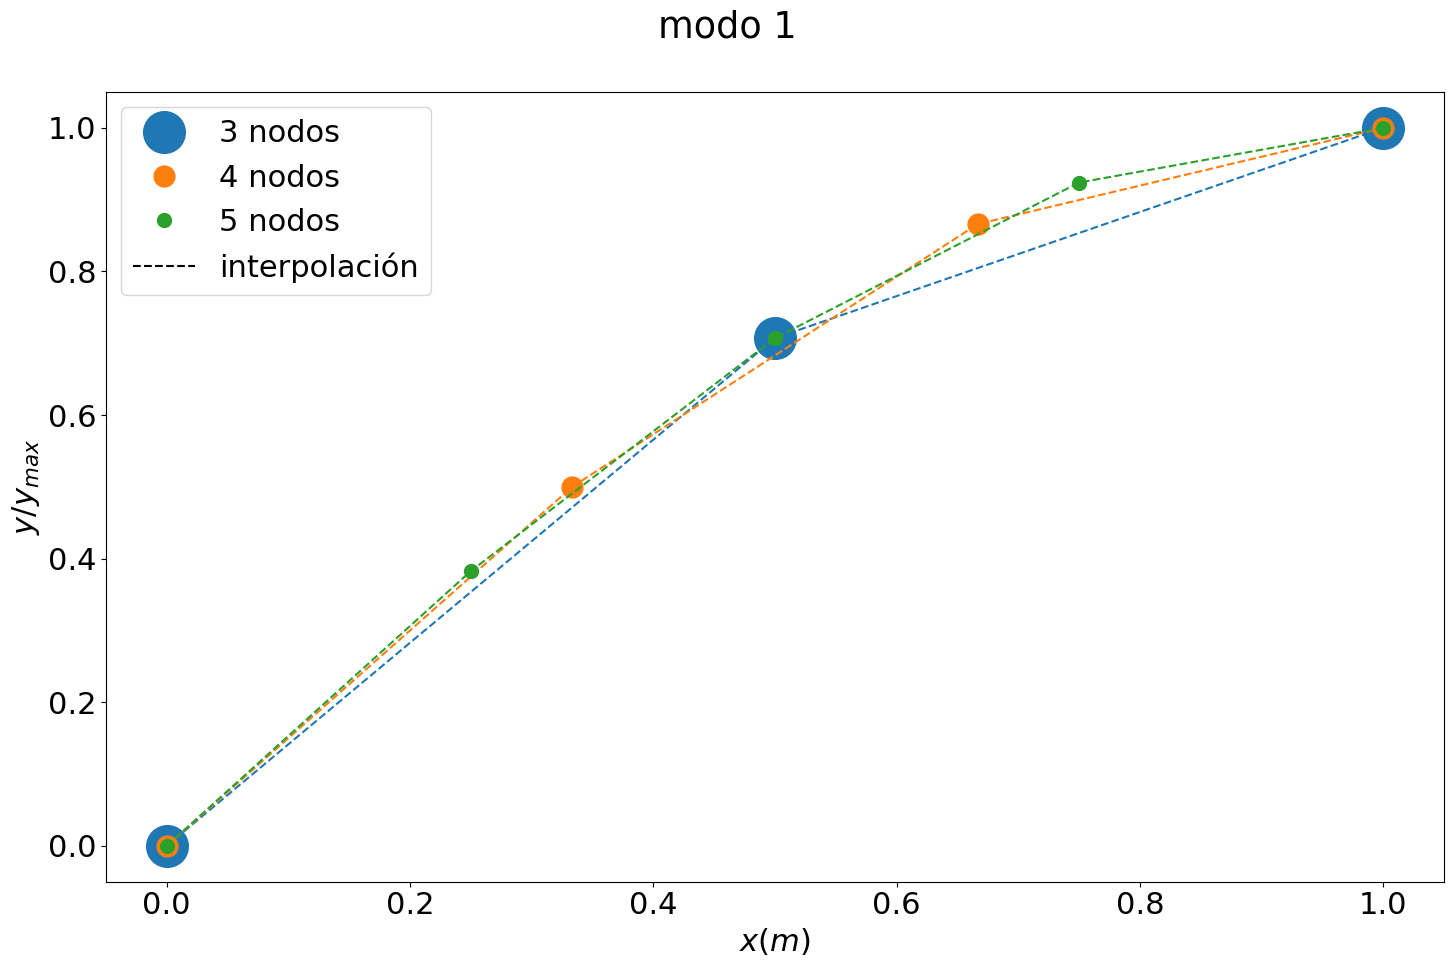

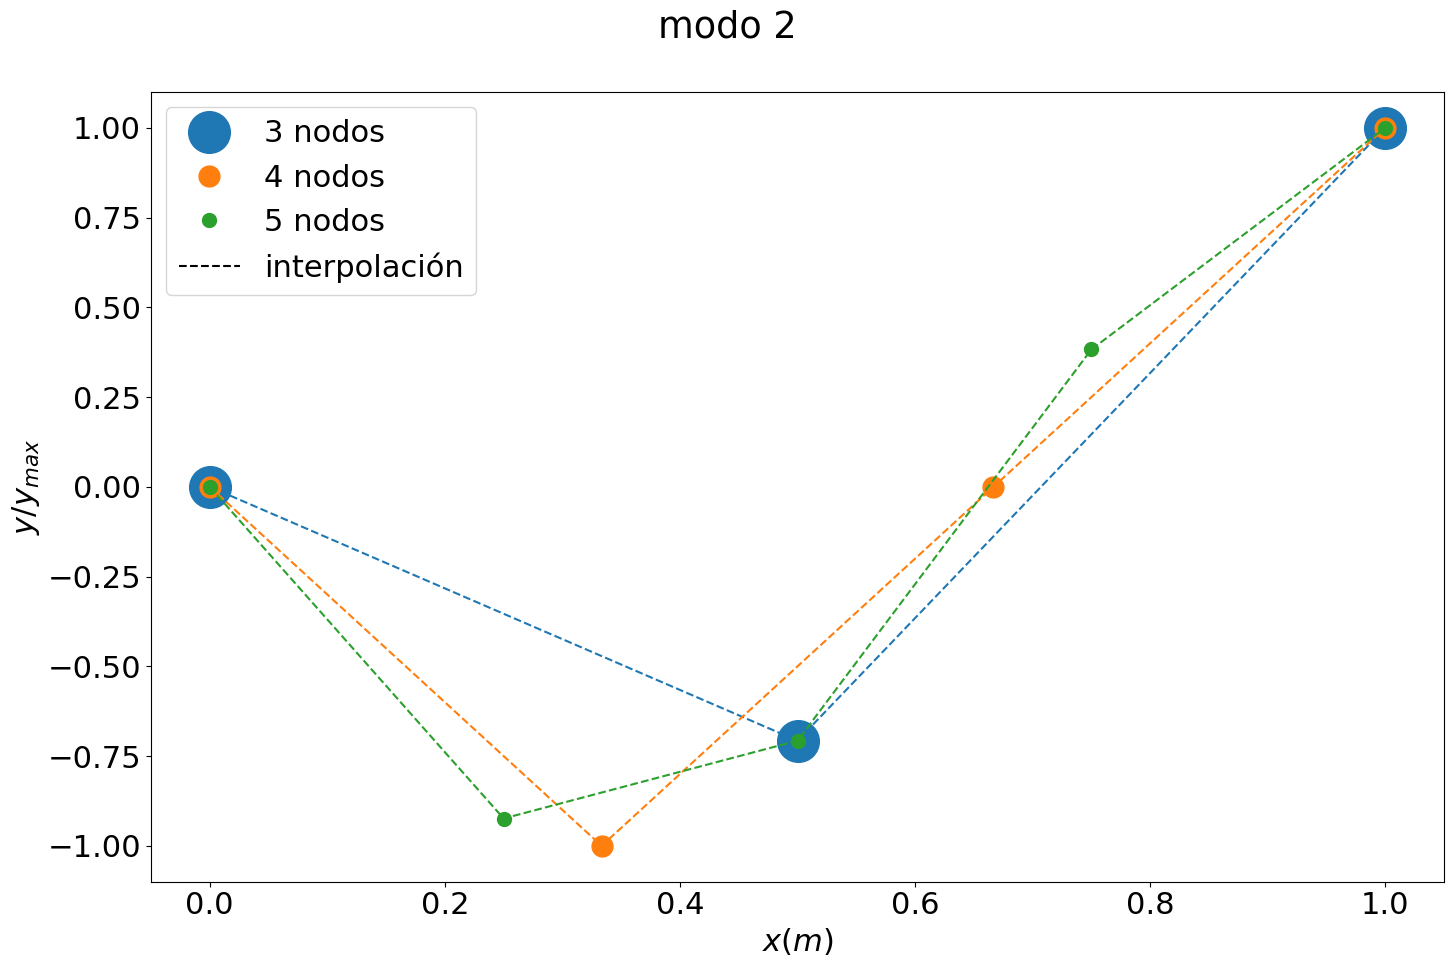

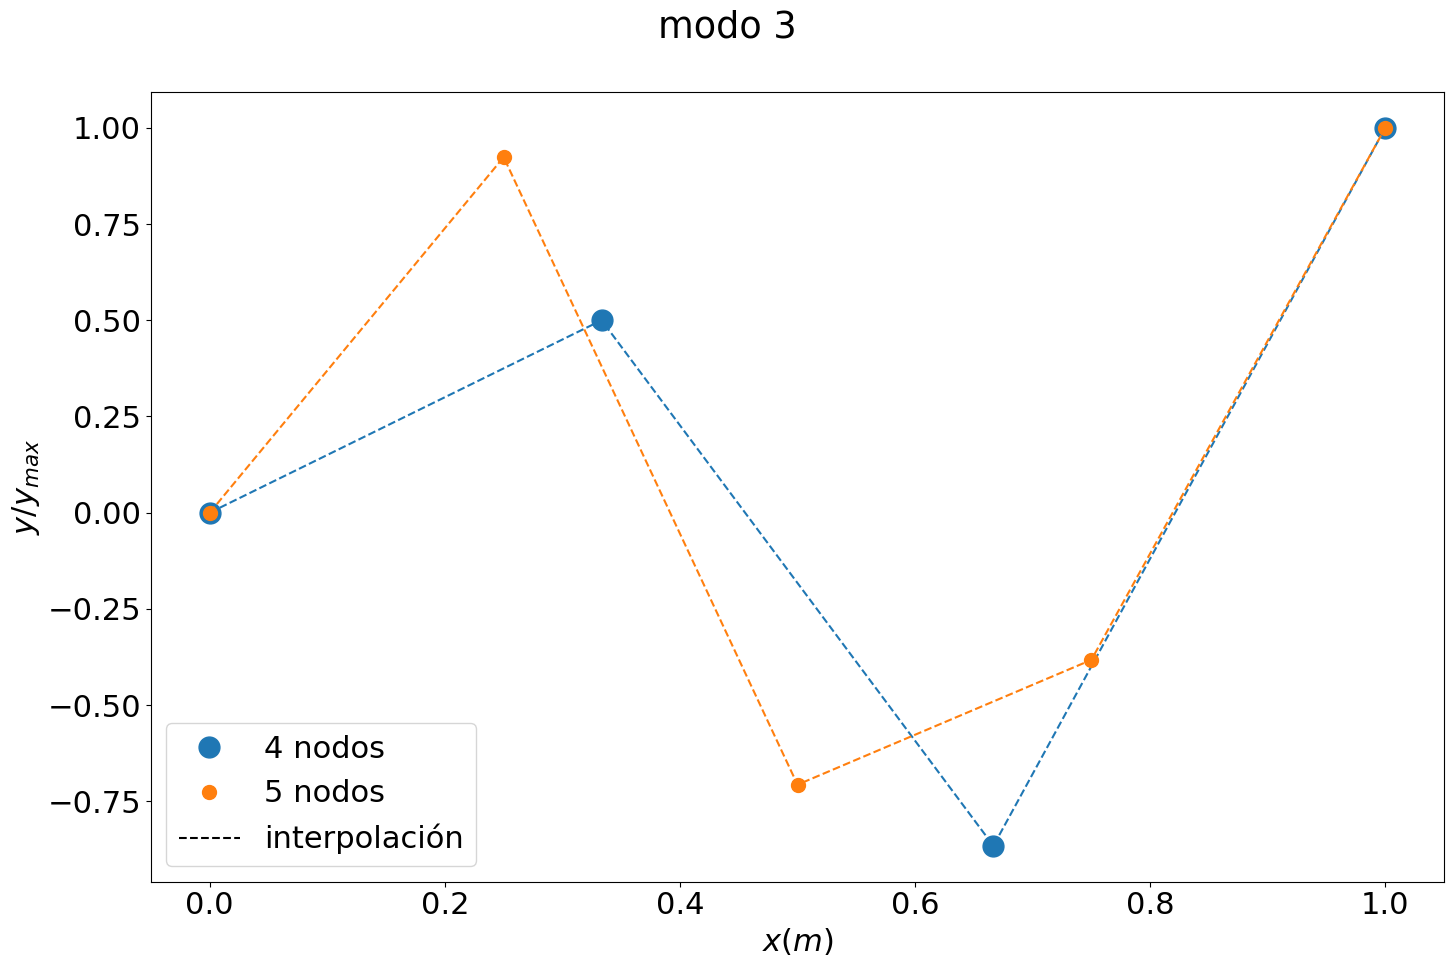

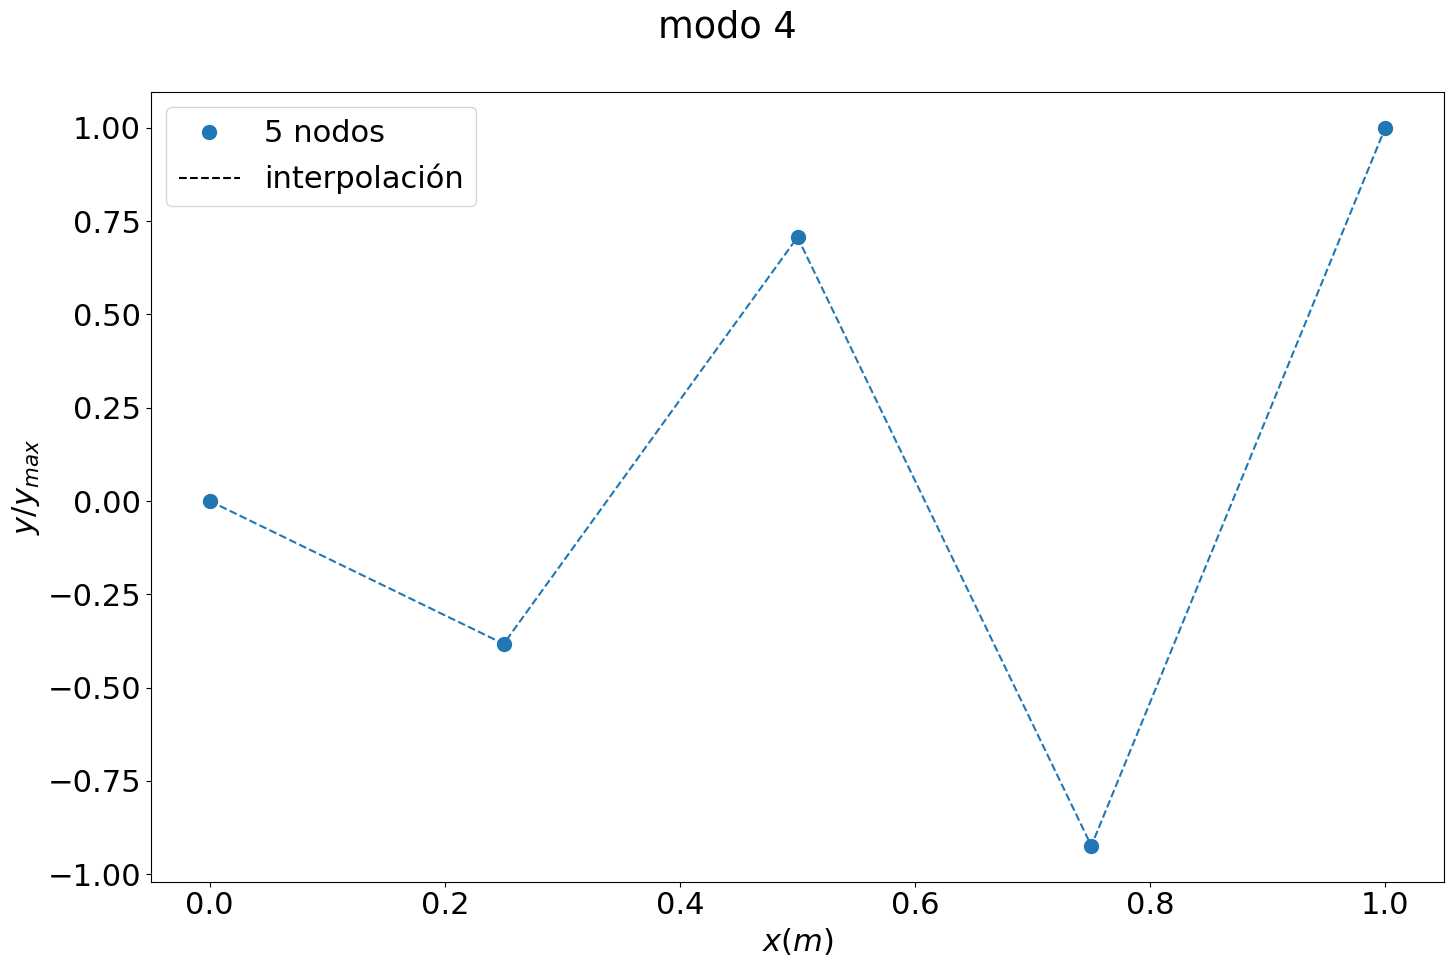

In [24]:
interpoline = mlines.Line2D([],[], linestyle = '--', color='k')
for mode in modes:
    ls = []
    fig, ax = plt.subplots()
    for NNODES in np.arange(3,6): #,4]:
        if mode > ds[NNODES-2][0].shape[1]:
            continue
        thismode = ds[NNODES-2][0][:,mode-1]
        ls.append(ax.plot(x[NNODES],y[NNODES][mode]/y[NNODES][mode][-1],'o', label=f'{NNODES} nodos', ms=30/(NNODES-2)))
        ax.plot(xx[NNODES][mode], yy[NNODES][mode]/y[NNODES][mode][-1], '--', c = ls[-1][0].get_color())
    solution_handles = [l[0] for l in ls]+[interpoline]
    solution_labels = [l[0].get_label() for l in ls]+['interpolación']
    ax.legend(handles = solution_handles, labels=solution_labels)
    ax.set_ylabel('$y/y_{max}$')
    ax.set_xlabel('$x (m)$')
    fig.suptitle(f'modo {mode}')
    fig.tight_layout()

In [86]:
ls[0][0].get_label()

'3 nodos'

ValueError: x and y must have same first dimension, but have shapes (3,) and (6,)

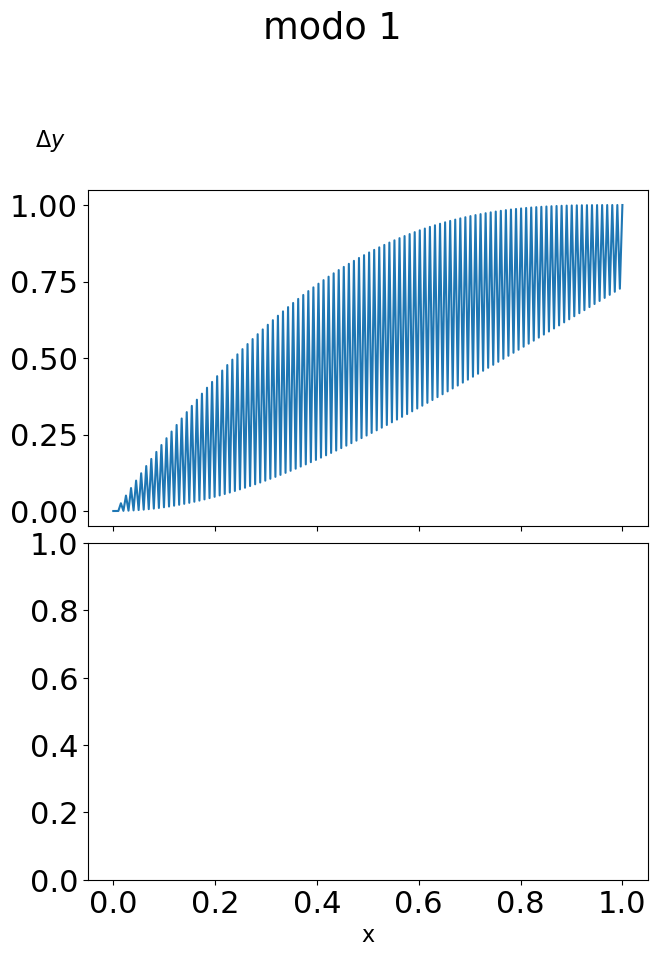

In [35]:
fig = pf.plotmodes(MODES, [2, 3, 4], dv, labels, modo_name, modo = modo , glstep=1)

In [8]:
%matplotlib inline

In [9]:
fig[0].get_axes()

[<AxesSubplot:>, <AxesSubplot:xlabel='x'>]

/home/mariano/modelizacion/SolucionesProblemas/Guia4-MEF-dt/Guia4-python/Ejercicio1/plotfrecs.py:34: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(lin,
/home/mariano/modelizacion/SolucionesProblemas/Guia4-MEF-dt/Guia4-python/Ejercicio1/plotfrecs.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


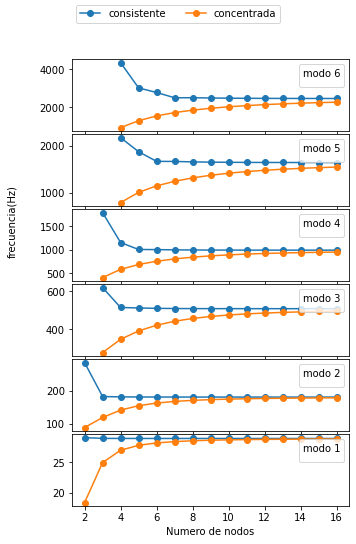

In [10]:
ws = [wtrans, wtrans_lump]
cases = ['consistente', 'concentrada']
name='transversal'
pf.plotfrecs(ws, cases, name)

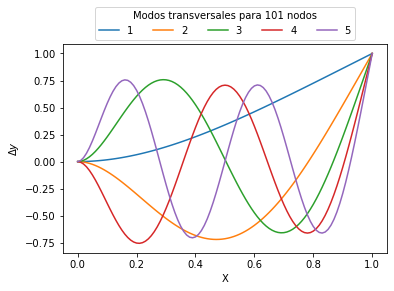

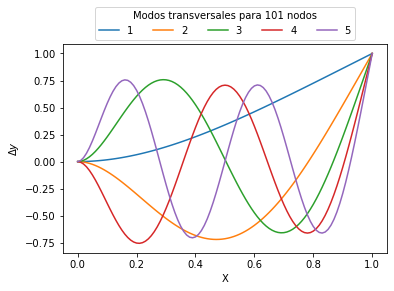

In [11]:
# los primeros 5 modos trans
pf.allmodesplot(dv[:,:5], 'transversales', fig_size=(4, 10))

In [28]:
import gmsh

In [62]:
gmsh.initialize()
modelname = 'ModosTransversales'
gmsh.model.add(modelname)
MN = np.hstack([V.MN, np.zeros([len(V.MN), 1])])
nodetags = np.linspace(1, len(V.MN), len(V.MN)).astype(int)
elementtags = np.linspace(1, len(V.MC)+1, len(V.MC)).astype(int)
Points = []
Points.append(gmsh.model.geo.addPoint(*np.append(MN[0],[1])))
Points.append(gmsh.model.geo.addPoint(*np.append(MN[-1],[1])))
L = gmsh.model.geo.addLine(*Points)
gmsh.model.geo.synchronize()
group = gmsh.model.addPhysicalGroup(1, [L])
gmsh.model.mesh.addNodes(1, L, nodetags, MN.ravel())
gmsh.model.mesh.addElements(1, L, [1], [elementtags], [V.MC.ravel()+1])
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)

imodo = 3

thisview = gmsh.view.add(f'modo{imodo}')
mode = dtrans[-1][0][::2,imodo-1].reshape(-1,1)
zeros = np.zeros((len(nodetags), 1))

omega = wtrans[-1,imodo-1]
T = 2*np.pi / (omega)
ts = np.linspace(0, T, 10)
#fig,ax = plt.subplots(1,len(ts), figsize=(15,5), sharey=True)

for i, t in enumerate(ts[:-1]):
    D = np.hstack([zeros, mode*np.sin(omega*t).reshape(-1,1),zeros])
    gmsh.view.addModelData(
        modo1, i, modelname,'NodeData', nodetags, D, t, numComponents=3 )

gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)

gmsh.write(f'Modo{imodo}.msh')

gmsh.fltk.run()

gmsh.finalize()

Info    : Writing 'Modo3.msh'...
Info    : Done writing 'Modo3.msh'
-------------------------------------------------------
Version       : 4.8.4
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20210428
Build host    : gmsh.info
Build options : 64Bit ALGLIB ANN Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen Fltk Gmm Hxt Jpeg[fltk] Kbipack Lapack[petsc] LinuxJoystick MathEx Med Mesh Metis Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OptHom PETSc Parser Plugins Png[fltk] Post QuadTri Solver TetGen/BR Voro++ Zlib[fltk]
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------
